# Label Distribution Smoothing

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

https://towardsdatascience.com/strategies-and-tactics-for-regression-on-imbalanced-data-61eeb0921fca

In [4]:
nga_clean = pd.read_csv('C:/Users/vicin/Desktop/DSSG/Nigeria/nga_clean_v1.csv')
nga_clean.head(2)

,hex_code,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,...,Optical_Depth_055,NDWI,NDVI,discrete_classification-proba_mean,discrete_classification_mean,avg_rad,cf_cvg,built,cnfd,Road_density
0,609534210041970687,2018.0,72.0,739.0,103.803738,5.523364,2.0,1.439252,1.140187,-124478.626168,...,2569.544731,-0.329164,1.449629,262.2,240.0,0.650088,46.097220,0.0,0.0,0.000000
1,609534214102056959,2018.0,72.0,701.0,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,...,2076.441603,-0.370748,1.165454,239.6,200.0,0.586569,45.833332,0.0,0.0,0.468752


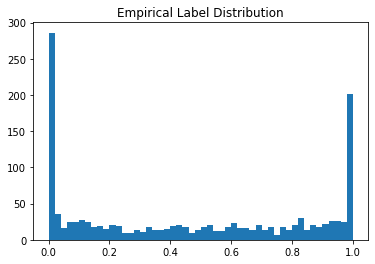

In [51]:
_= plt.hist(nga_clean['dep_sanitation_sev'], bins=50)
_= plt.title('Empirical Label Distribution')

In [30]:
from scipy.ndimage import gaussian_filter1d
# https://github.com/YyzHarry/imbalanced-regression


def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

In [27]:
# "Ns" is the number of total samples
Ns = nga_clean.shape[0]

# assign each label to its corresponding bin (start from 0)
bin_index_per_label = list(pd.cut(nga_clean['dep_sanitation_sev'], bins = 50, labels = list(range(50))))

In [47]:
from collections import Counter
from scipy.ndimage import convolve1d
# from utils import get_lds_kernel_window

# calculate empirical (original) label distribution: [Nb,]
# "Nb" is the number of bins
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

# lds_kernel_window: [ks,], here for example, we use gaussian, ks=5, sigma=2
lds_kernel_window = get_lds_kernel_window(kernel='gaussian', ks=10, sigma=0.75)
# calculate effective label distribution: [Nb,]
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

50
[0.00000000e+00 3.35462628e-04 2.85655008e-02 4.11112291e-01
 1.00000000e+00 4.11112291e-01 2.85655008e-02 3.35462628e-04
 0.00000000e+00]
[300 159  49  43  46  49  44  37  35  35  35  30  22  21  24  24  29  27
  26  30  33  35  32  27  27  27  31  27  26  34  36  31  29  29  32  30
  27  22  27  30  38  44  36  36  37  39  46  53 119 212]


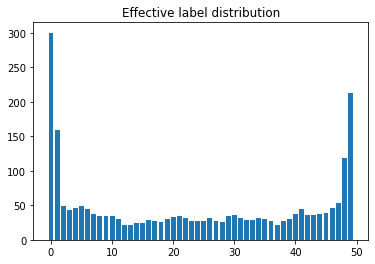

In [52]:
_= plt.bar(range(50), eff_label_dist)
_= plt.title('Effective label distribution')

Now that the effective label density is available, techniques for addressing class imbalance problems can be directly adapted to the DIR context. For example, a straightforward adaptation can be the cost-sensitive re-weighting method, where we reweight the loss function by multiplying it by the inverse of the LDS estimated label density for each target.

In [ ]:
# With the estimated effective label distribution, one straightforward option is to use the loss re-weighting scheme:

from loss import weighted_mse_loss

# Use re-weighting based on effective label distribution, sample-wise weights: [Ns,]
eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
weights = [np.float32(1 / x) for x in eff_num_per_label]


Now I can compute the weighted loss

In [ ]:
# calculate loss
loss = weighted_mse_loss(preds, labels, weights=weights)